In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
#train_samples = 400  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [2]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [3]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import HonestRandomForestClassifier


# Define the classifiers to be compared in the study.
#
# Note that we use a variant of the logistic regression model that can
# automatically tune its regularization parameter.
#
# For a fair comparison, we should run a hyper-parameter search for all the
# classifiers but we don't do it here for the sake of keeping the example code
# concise and fast to execute.
lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)

N_TREES=4000
MAX_FEATURES=1.0
rfc = RandomForestClassifier(
    n_estimators=N_TREES,
    max_features=MAX_FEATURES,
    random_state=42
)
hrf = HonestRandomForestClassifier(
    n_estimators=N_TREES,
    #max_samples=1.6,
    max_features=MAX_FEATURES,
    #max_features=1.0,
    #bootstrap=True,
    # stratify=True,
    random_state=42,
    honest_prior="ignore",
    #honest_fraction=0.25
)


clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
    (hrf, "Honest Random Forest")
]

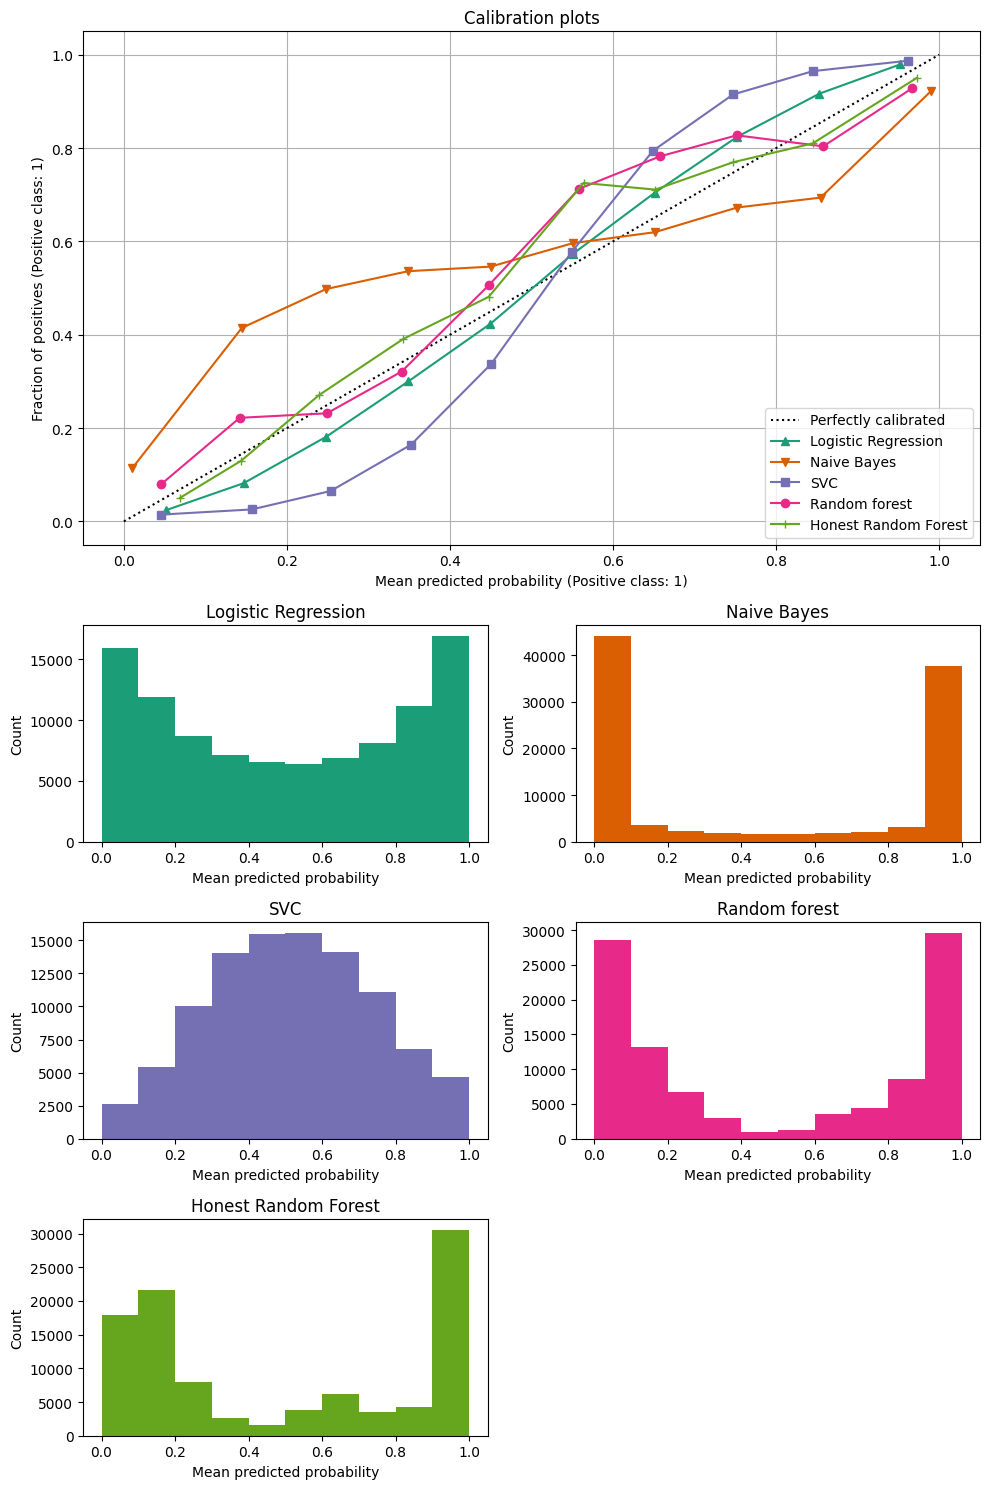

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "+"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()